In [2]:
# 设计思想：
#设计思想是使用K折交叉验证来评估模型的性能。

# 首先，将数据集分成K个fold，其中K是预先定义的折叠数量。然后，使用K折交叉验证来循环训练和测试模型。

# 在训练阶段，使用K-1个fold的数据作为训练数据，剩下的1个fold作为测试数据。使用数据加载器将训练数据划分为批次，并在每个批次中进行模型训练。

# 在每个epoch和batch的训练循环中，通过模型的前向传播计算预测结果，并与真实标签计算损失。然后，通过优化器和学习率调度器来更新模型的参数。

#  训练完成后，保存已训练的模型，并开始进行测试。

# 在测试阶段，使用模型进行前向传播，计算预测结果，并统计正确预测的数量。然后，计算准确率并打印结果。

# 最后，输出每个fold的准确率和平均准确率，以评估模型的性能。

# 该设计思想是利用了K折交叉验证的优点，可以通过进行多次训练和测试来评估模型在不同数据子集上的性能

In [3]:
import os
from os import path
import json
import collections

import numpy as np
import pandas as pd
import cv2
from PIL import Image
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision import datasets, transforms, models
from torch.utils import data as torch_data
from tqdm import tqdm
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

* The below statement will help in better error intepretation for CUDA.

In [4]:
CUDA_LAUNCH_BLOCKING="1"

In [5]:
base_path = '../input/herbarium-2021-fgvc8'
train_path = os.path.join(base_path, "train/")
train_metadata_path = os.path.join(train_path, "metadata.json")
test_path = os.path.join(base_path, "test/")
test_metadata_path = os.path.join(test_path, "metadata.json")

In [6]:
# 打开训练数据集的元数据文件，并使用json.load函数将其加载为Python字典对象，存储在metadata变量中。
# 然后使用keys()方法查看metadata字典中的所有键
with open(train_metadata_path) as json_file:
    metadata = json.load(json_file)
    
metadata.keys()

dict_keys(['annotations', 'categories', 'images', 'info', 'licenses', 'institutions'])

In [7]:
# 打印出数据文件中的键值
print(metadata["annotations"][0])
print(metadata["images"][0])
print(metadata["categories"][0])
print(metadata["licenses"][0])
print(metadata["institutions"][0])

{'category_id': 60492, 'id': 1814367, 'image_id': 1814367, 'institution_id': 0}
{'file_name': 'images/604/92/1814367.jpg', 'height': 1000, 'id': 1814367, 'license': 0, 'width': 678}
{'family': 'Orchidaceae', 'order': 'Asparagales', 'name': 'Aa calceata (Rchb.f.) Schltr.', 'id': 0}
{'id': 0, 'name': 'Public Domain Dedication', 'url': 'http://creativecommons.org/publicdomain/zero/1.0/'}
{'id': 0, 'name': 'New York Botanical Garden'}


In [8]:
# 在类的构造函数__init__中，打开并加载指定的元数据文件，将其存储在metadata变量中。
class Create_Image_Paths():
    def __init__(self,datafile):
        with open(datafile) as json_file:
            self.metadata = json.load(json_file)
# create_dataframe方法用于创建数据框。它使用zip函数同时迭代metadata["annotations"]和metadata["images"]，
# 并通过比较annotation["image_id"]和image["id"]来确保它们匹配    
    def create_dataframe(self):
        ids = []
        categories = []
        paths = []
# 在迭代过程中，将image["id"]添加到ids列表，将annotation["category_id"]添加到categories列表，将image["file_name"]
# 添加到paths列表。
        for annotation, image in zip(metadata["annotations"], metadata["images"]):
            assert annotation["image_id"] == image["id"]
            ids.append(image["id"])
            categories.append(annotation["category_id"])
            paths.append(image["file_name"])
# 使用pd.DataFrame函数将ids、categories和paths作为字典创建数据框，并将其存储在self.df变量中。       
        self.df = pd.DataFrame({"id": ids, "category": categories, "path": paths})
# 创建字典d_categories，其中键是metadata["categories"]中的id，值是对应的name。类似地，创建字典d_families
# 和d_orders，分别存储family和order的对应关系
        d_categories = {category["id"]: category["name"] for category in metadata["categories"]}
        d_families = {category["id"]: category["family"] for category in metadata["categories"]}
        d_orders = {category["id"]: category["order"] for category in metadata["categories"]}
# 使用map方法，将self.df["category"]中的值映射为d_categories中的对应值，并将结果存储在self.df["category_name"]列中。
# 类似地，将self.df["category"]映射为d_families和d_orders中的对应值，分别存储在self.df["family_name"]和
# self.df["order_name"]列中
        self.df["category_name"] = self.df["category"].map(d_categories)
        self.df["family_name"] = self.df["category"].map(d_families)
        self.df["order_name"] = self.df["category"].map(d_orders)
        

In [9]:
# 创建一个名为Image_Paths_Obj的Create_Image_Paths对象，使用train_metadata_path作为参数传递给构造函数
Image_Paths_Obj = Create_Image_Paths(train_metadata_path)
# 调用create_dataframe方法创建数据框，并将其存储在Image_Paths_Obj.df变量中
Image_Paths_Obj.create_dataframe()
# 使用.head()方法显示数据框的前几行
Image_Paths_Obj.df.head()

,id,category,path,category_name,family_name,order_name
0,1814367,60492,images/604/92/1814367.jpg,Thysanocarpus curvipes Hook.,Brassicaceae,Brassicales
1,1308257,10824,images/108/24/1308257.jpg,Cassia grandis L.f.,Fabaceae,Fabales
2,1270453,33076,images/330/76/1270453.jpg,Leptospermum whitei Cheel,Myrtaceae,Myrtales
3,1123834,24799,images/247/99/1123834.jpg,Fallopia scandens (L.) Holub,Polygonaceae,Caryophyllales
4,1042410,17018,images/170/18/1042410.jpg,Cyperus dentatus Torr.,Cyperaceae,Poales


In [10]:
# 计算Image_Paths_Obj.df数据框按类别分组后的类别数量，
# 并将结果存储在n_class变量中。然后，可以打印n_class的值，以获取类别数量
n_class = len(Image_Paths_Obj.df.groupby('category'))
n_class

64500

In [11]:
Image_Paths_Obj.df.path[0]

'images/604/92/1814367.jpg'

In [12]:
# 构造函数__init__中，将传入的数据框存储在self.dfx变量中
class Data_Visualization:
    def __init__(self,df):
        self.dfx = df
# visualize_by_id方法用于可视化指定类别的样本。首先从数据框中随机选择6个样本，
# 如果传入了_id参数，则从数据框中选择该类别的样本。然后，调用visualize_train_batch方法进行可视化        
    def visualize_by_id(self, _id=None):
        tmp = self.dfx.sample(6)
        if _id is not None:
            tmp = self.dfx[self.dfx["category"] == _id].sample(6)
            
        self.visualize_train_batch(
            tmp["path"].tolist(), 
            tmp["category_name"].tolist(),
            tmp["family_name"].tolist(),
            tmp["order_name"].tolist())
  # visualize_train_batch方法用于可视化给定的图像路径、类别、科属和目。它创建一个16x16的画布，并使用循环遍历每个样本。对于每个样本，
 # 加载图像并转换为RGB格式，然后在子图中显示图像。标题显示了样本的类别、科属和目。最后，显示画布   
    def visualize_train_batch(self,paths, categories, families, orders):
        plt.figure(figsize=(16, 16))
   # 遍历了paths、categories、families和orders列表，并通过enumerate函数获取索引和对应的元素
  # 依次将path、category、family和order分配给对应的变量。
        for ind, info in enumerate(zip(paths, categories, families, orders)):
            path, category, family, order = info
  # 使用plt.subplot函数创建一个2行3列的子图，并将当前子图的索引设置为ind + 1。      
            plt.subplot(2, 3, ind + 1)
            image = cv2.imread(os.path.join(train_path, path))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            plt.imshow(image)
        # plt.title函数添加了一个标题，包含了family、order和category的信息
            plt.title(
                f"FAMILY: {family} ORDER: {order}\n{category}", 
                fontsize=10,
            )
            plt.axis("off")
        plt.show()

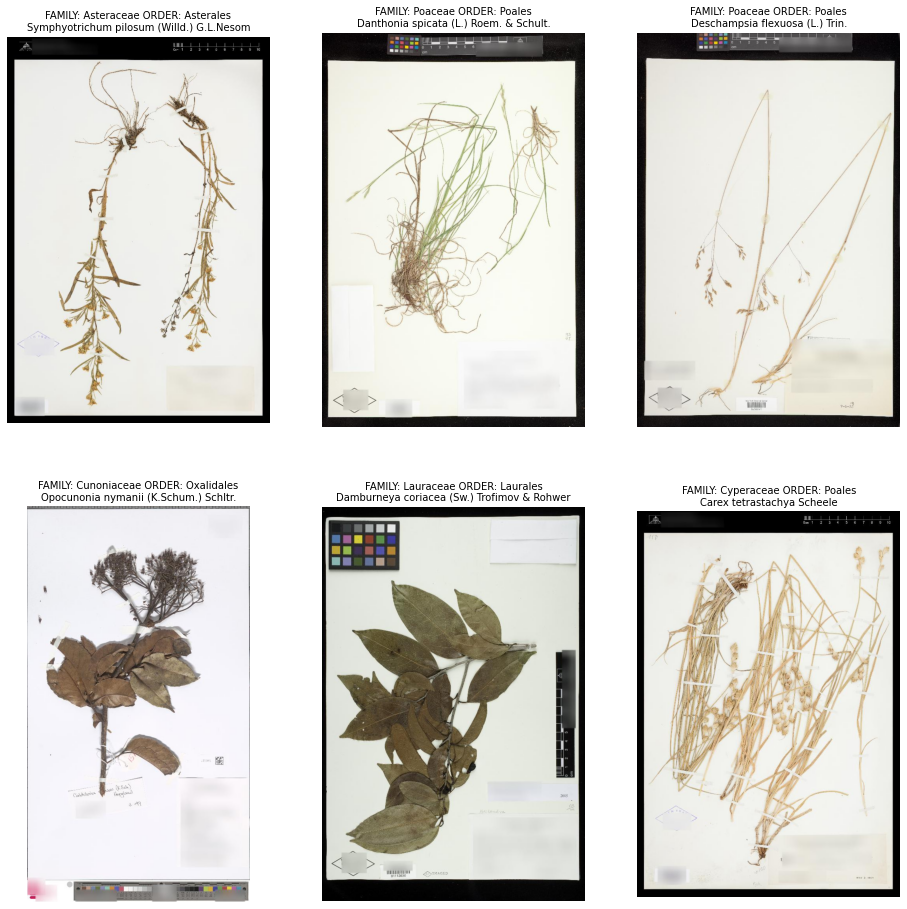

In [13]:
# 创建一个名为data_viz的Data_Visualization对象，使用Image_Paths_Obj.df作为参数传递给构造函数
data_viz = Data_Visualization(Image_Paths_Obj.df)
# 调用visualize_by_id方法进行可视化。由于没有传递任何参数给visualize_by_id，将随机选择6个样本进行可视化
data_viz.visualize_by_id()

In [14]:
# 思路：定义了一个自定义数据集类DataRetriever，用于加载和处理数据集中的图像数据，以及一个函数get_transforms，
# 用于获取数据转换操作。这样，可以方便地在训练模型时使用自定义数据集和数据转换操作

# DataRetriever类继承了torch_data.Dataset类，并实现了__init__、__len__和__getitem__方法
class DataRetriever(torch_data.Dataset):
# 在__init__方法中，接收路径列表paths、类别列表categories（可选参数）、数据转换操作transforms（可选参数）
# 和基本路径base_path（默认为train_path）。将这些参数存储在类的成员变量中
    def __init__(self, paths, categories=None,transforms=None,base_path=train_path):
        self.paths = paths
        self.categories = categories
        self.transforms = transforms
        self.base_path = base_path
# __len__方法返回数据集的长度，即路径列表paths的长度          
    def __len__(self):
        return len(self.paths)
# __getitem__方法根据给定的索引index，打开对应路径的图像，并进行必要的转换操作。
# 若transforms不为None，则应用转换操作。如果categories为None，则只返回图像。否则，返回图像和对应的类别    
    def __getitem__(self, index):
        img = Image.open(os.path.join(self.base_path, self.paths[index]))
        if self.transforms:
            img = self.transforms(img)
        if self.categories is None:
            return img
        y = self.categories[index] 
        return img, y
    
 # get_transforms函数返回一个transforms.Compose对象，
# 其中包含了一系列的数据转换操作，如随机旋转、随机水平翻转、调整图像大小、中心裁剪、转换为张量、标准化等   
def get_transforms():
    return transforms.Compose([
        transforms.RandomRotation(10),                         # 随机旋转图像，旋转角度范围为正负 10 度  
        transforms.RandomHorizontalFlip(),                     # 以 50% 的概率对图像进行水平翻转
        transforms.Resize(224),                               # 将图像的最短边缩放至 224 像素
        transforms.CenterCrop(224),                           # 在图像的中心裁剪出 224x224 大小的区域
        transforms.ToTensor(),                                # 将图像转换为 PyTorch 的张量
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])            # 对图像进行标准化，使用给定的均值和标准差进行归一化。
    ])
            

In [15]:
# 创建一个DataRetriever对象，并准备训练数据集。通过设置随机种子，可以确保每次运行时的随机结果一致

# Image_Paths_Obj.df数据框中的图像路径和类别分别存储在tmp_path和tmp_category列表中
tr_df = Image_Paths_Obj.df
tmp_path = tr_df["path"].tolist()
tmp_category = tr_df["category"].tolist()
BATCH = 10
# 使用DataRetriever类创建了一个train_data_retriever对象，
# 传入了tmp_path和tmp_category列表作为路径和类别参数，并通过get_transforms()函数获取数据转换操作
train_data_retriever = DataRetriever(
    tmp_path,
    tmp_category,
    transforms=get_transforms(),
)
# 使用torch.manual_seed(42)设置了一个随机种子，目的是确保实验的可复现性
torch.manual_seed(42)

In [16]:
# 使用models.resnet34(pretrained=True)创建了一个预训练的ResNet-34模型，并将其存储在Base_Model1变量中
Base_Model1 = models.resnet34(pretrained=True)
# 遍历Base_Model1.parameters()，将所有参数的requires_grad属性设置为False，以冻结模型的所有参数，使其在训练过程中不被更新
for param in Base_Model1.parameters():
    param.requires_grad = False

torch.manual_seed(42)
Base_Model1.fc = nn.Linear(512, n_class, bias=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [17]:
# 设置一个三元表达式来选择设备。如果CUDA可用，它将选择"cuda:0"作为设备；否则，它将选择"cpu"作为设备
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [18]:
DEVICE

device(type='cuda', index=0)

In [19]:
# 用于测量代码块的运行时长
%%time
EPOCHS = 10
criterion = nn.CrossEntropyLoss()

UsageError: Line magic function `%%time` not found.


In [ ]:
# 定义了一个变量k_folds来指定折叠的数量，然后使用KFold类创建了一个K折交叉验证对象kfold
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)
# 使用kfold.split(train_data_retriever)来获取每个折叠的训练和测试索引
for fold, (train_ids, test_ids) in enumerate(kfold.split(train_data_retriever)):
    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    # 使用torch.utils.data.SubsetRandomSampler创建了训练和测试数据的子采样器
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    # 使用torch.utils.data.DataLoader创建训练和测试数据的数据加载器
    trainloader = torch.utils.data.DataLoader(
                      train_data_retriever, 
                      batch_size=BATCH, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                      train_data_retriever,
                      batch_size=BATCH, sampler=test_subsampler)
    
    #将模型Base_Model1移动到设备DEVICE上，并设置优化器和学习率调度器
    model = Base_Model1.to(DEVICE)
    epochs = 0
    #设置优化器
    optimizer = torch.optim.Adam(Base_Model1.parameters(), lr=0.01)
    #设置学习率的调度器
    step_size = 4*len(trainloader)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, step_size)
   # 在每个折叠的训练循环中，遍历训练数据的批次，将数据和标签移动到设备上，通过模型进行前向传播，并计算损失     
    
    # 使用优化器更新模型的参数，并在每个epoch和batch的特定条件下打印中间结果
    for epoch in range(epochs, EPOCHS):
        # Print epoch
        print(f'Starting epoch {epoch+1}')
        # Run the training batches
        for b, (X_train, y_train) in enumerate(trainloader):
            
            b+=1
            # 将数据和标签移动到设备上（使用.cuda()方法将它们转移到GPU上进行加速计算）
            X_train = X_train.cuda()
            y_train = y_train.cuda()
            # 将数据输入到模型中，并通过调用model.forward()方法进行前向传播，得到预测结果
            y_pred = model.forward(X_train)
            # 使用预测结果和真实标签计算损失，使用criterion作为损失函数
            loss = criterion(y_pred, y_train)
            # 使用optimizer.zero_grad()方法将优化器的梯度缓存清零，以确保每个批次的梯度不会累积
            optimizer.zero_grad()
            # 调用loss.backward()方法计算损失函数关于模型参数的梯度
            loss.backward()
            # 使用学习率调度器的scheduler.step()方法来调整学习率
            scheduler.step()
            # 调用optimizer.step()方法来更新模型的参数，使用优化器根据计算得到的梯度来更新参数
            optimizer.step()
            # 在每个epoch和batch的特定条件下，使用if b%20 == 0来判断是否打印中间结果。
            # 如果条件满足，打印当前epoch、batch和损失值
            if b%20 == 0:
                print(f'epoch: {epoch:2}  batch: {b:4}  loss: {loss.item():10.8f}') 
                
            
    # 训练过程已经完成
    print('Training process has finished. Saving trained model.')
    
    # 打印开始训练
    print('Starting testing')
    
    # 保存已训练的模型。
    
    save_path = f'model-fold-{fold}.pth'
    torch.save(model.state_dict(), save_path)
    
# 评估当前fold的结果
    correct, total = 0, 0
    with torch.no_grad():
        
        # 将数据和标签移动到设备上（使用.cuda()方法将它们转移到GPU上进行加速计算）
        for b, (X_test, y_test) in enumerate(testloader):
            b+=1
            X_test = X_test.cuda()
            y_test = y_test.cuda()
            
            # 将数据输入到模型中，并通过调用model.forward()方法进行前向传播，得到预测结果y_val
            y_val = model.forward(X_test)
            # 使用torch.max(y_val.data, 1)[1]来获取每个样本预测结果的索引，
            # 然后将其与真实标签进行比较，统计正确预测的数量
            predicted = torch.max(y_val.data, 1)[1] 
            # 累加总样本数和正确预测的数量以计算准确率
            total += y_test.size(0)
            correct += (predicted == y_test).sum().item()
            
        
        # 对于当前fold，打印其准确率
        print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
        print('--------------------------------')
        results[fold] = 100.0 * (correct / total)
            
            
# 输出每个fold的准确率和平均准确率
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
sum = 0.0
for key, value in results.items():
    print(f'Fold {key}: {value} %')
    sum += value
print(f'Average: {sum/len(results.items())} %')                   